# Asteroid Size-Frequency Distribution using Monte Carlo
Naunet Leonhardes-Barboza and Hannah Stickler

This jupyter notebook aims to show how asteroid frequency distribution can be extrapolated from craters on the Moon via crater scaling laws, and we compare our calculated asteroid diameter results to current NEOs from the JPL Horizons Small Bodies database.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

We will now read in the databases we are using for our analysis.

In [17]:
craters= pd.read_csv('AstroStats_Robbins_Moon.csv', sep=',')
asteroids = pd.read_csv('032822_NEOs_defined_diameters.csv', sep=',')

We care about the asteroid diameter sizes from the JPL NEOs database, so we will select for that only.

In [15]:
display(asteroids[["diameter"]])

a_diams = asteroids.loc[:,"diameter"]
a_diams = a_diams.to_numpy()
# we should do more analysis on the limitations of this database, and bias selection effects

,diameter
0,16.840
1,4.200
2,37.675
3,1.000
4,1.000
...,...
1262,1.600
1263,2.000
1264,26.000
1265,11.600


### Cleaning Data
We want to clean the Robbins lunar crater database, so that we can model for craters with well-defined longitude and latitudes. This way we can select for craters in upper left region of moon (0 < lat < 90) and (270 < long < 360).

In [21]:
c_craters = craters.dropna(subset=["LAT_CIRC_IMG", "LON_CIRC_IMG"])
updated_craters = c_craters[ (c_craters["LAT_CIRC_IMG"] < 90) & (c_craters["LAT_CIRC_IMG"] > 0) & (c_craters["LON_CIRC_IMG"] > 270) & (c_craters["LON_CIRC_IMG"] < 360)]
display(updated_craters)

#convert to numpy for later use
updated_craters_diameter = updated_craters.loc[:,'DIAM_CIRC_IMG']
updated_craters_diameter = updated_craters_diameter.to_numpy() #Convert to numpy

,Unnamed: 0,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,DIAM_CIRC_SD_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,...,DIAM_ELLI_ANGLE_IMG,LAT_ELLI_SD_IMG,LON_ELLI_SD_IMG,DIAM_ELLI_MAJOR_SD_IMG,DIAM_ELLI_MINOR_SD_IMG,DIAM_ELLI_ANGLE_SD_IMG,DIAM_ELLI_ECCEN_SD_IMG,DIAM_ELLI_ELLIP_SD_IMG,ARC_IMG,PTS_RIM_IMG
1,1,00-1-000001,44.776300,328.602,44.408300,329.04600,249.8400,5.996210,289.44000,245.78600,...,127.0030,0.011178,0.015101,1.052780,0.209035,0.357296,0.005100,0.004399,0.627328,2785
31,31,00-1-000031,34.259500,342.856,34.207500,342.93300,1198.3900,12.683100,1212.14000,1186.65000,...,51.8645,0.023243,0.032696,1.962580,1.549250,3.954180,0.009770,0.002125,0.255605,494
764,764,01-1-000730,76.799900,272.668,76.793800,272.62500,46.5693,1.363840,49.97010,43.85480,...,16.2203,0.002134,0.011040,0.203481,0.147399,1.204440,0.008484,0.006016,0.891846,387
766,766,01-1-000732,74.810400,272.015,74.800200,272.02300,133.6810,1.504030,135.14200,132.17500,...,135.7530,0.004195,0.009334,0.203015,0.237271,4.066500,0.010745,0.002393,0.570028,548
778,778,01-1-000744,60.626100,270.233,60.626200,270.23300,9.2906,0.165078,9.53965,9.02948,...,55.2166,0.000557,0.001137,0.041647,0.040206,3.849580,0.017316,0.006588,1.000000,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33024,462359,04-3-004313,40.187700,276.701,40.186400,276.66500,13.7234,0.202396,13.78580,11.08700,...,90.0338,0.000373,0.001289,0.018258,0.083050,0.533942,0.008279,0.009459,0.344405,58
33025,462360,04-3-004314,34.601500,289.924,34.415800,290.22600,29.7096,0.502680,51.95150,32.80420,...,143.9430,0.023646,0.033799,2.413180,0.434701,0.627269,0.024837,0.076498,0.219984,201
34990,464430,05-1-002192,0.157047,355.428,0.373598,355.36700,34.8588,0.359589,50.37160,36.57070,...,106.3730,0.082179,0.011056,5.029090,1.435830,3.104170,0.082232,0.147768,0.240491,50
37417,548247,05-2-000040,0.010728,272.678,0.011832,272.68900,23.4894,0.833095,24.77770,22.17450,...,70.8919,0.003772,0.003771,0.411259,0.298248,3.552300,0.038347,0.023871,0.569904,116


### Defining Constants
We reference the crater scaling laws outlined by LeFuerve 2011.

In [23]:
#referencing LeFeurve 2011 A.59-A.63, crater scaling laws 
#https://www.sciencedirect.com/science/article/pii/S0019103511000947

#diameter of crater that is affected by Moon gravity according to Holsapple 1993
D_m = 8.5 #km

gm = .00162 #surface gravity of the moon in km/s
g = 0.0098 #surface gravity Earth

D_trans = (gm / g) * D_m

#scaling parameters for porous materials taken from Holsapple and Housen (2007) 
#https://www.researchgate.net/publication/221986000_A_crater_and_its_ejecta_An_interpretation_of_Deep_Impact
K = 1.03
v1 = 0.17
v2 = 0.332
u = 0.41 #observed porosity value for moderate porosity soils

#p and p0 are density of asteroid then Moon

p = 2 #g/m^3 - just grabbed the educated assumption of 2, as opposed to krasinki
p0 = 3.34 #g/cm^3

#p0 given by this paper https://link.springer.com/article/10.1023/A:1006353510204
#p pointed to in this wiki? https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics#:~:text=Krasinsky%20et%20al.,and%205.32%20g%2Fcm3.

In [24]:
#Work on Monte Carlo, assume that Ds = D

diameters = [] #list of asteroid diameters

for _ in range (len(a_diams)):
    
    crater_sample = random.choice(updated_craters_diameter) #randomly sampling our data set
    
    if (crater_sample >= D_trans):
        crater_sample = 0.98 * D_trans**(0.079) * crater_sample**(0.921)
        
    #defining the equations to go from crater diameter to asteroid diameter
    dt = crater_sample/1.56
    d_perp = dt*np.sin(np.pi / 2)**(-2*v1)
    d = ((K**(-1)*d_perp*u**(-2*v1)*g**(v1)*(p0/p)**(v2))**(1/(1-v1)))
    
    #calulcated asteroid diameters
    diameters.append(d)

In [25]:
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams.update({'font.size': 14})
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

def format_legend():
    leg = plt.legend(framealpha=1, loc = 'upper right', fontsize = 12, borderpad = 0.5)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_linewidth(1.1)
    leg.get_frame().set_boxstyle('Round', pad=0.05, rounding_size=-0.0001)

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


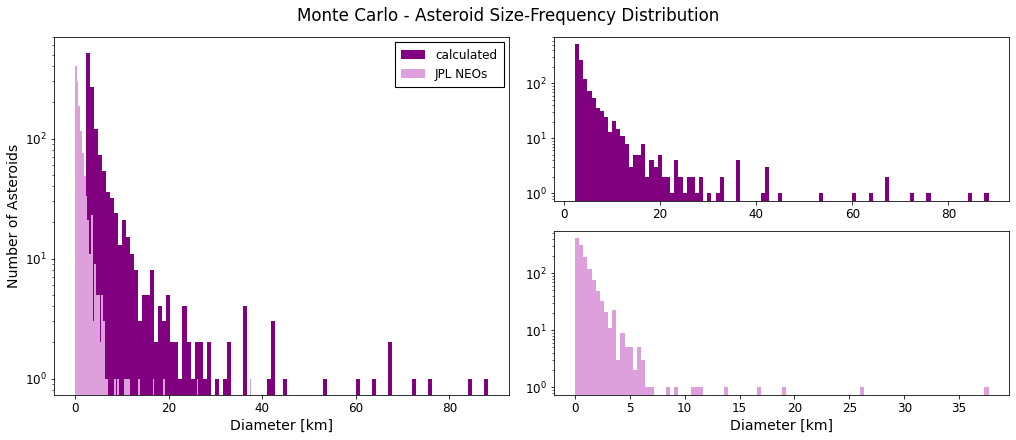

In [26]:
fig = plt.figure(figsize=(14, 6), constrained_layout=True)
spec = fig.add_gridspec(2, 2)
fig.suptitle("Monte Carlo - Asteroid Size-Frequency Distribution")

ax0 = fig.add_subplot(spec[:, 0])
ax0.hist(diameters, bins = 100, color = 'purple', label = 'calculated')
ax0.hist(a_diams, bins = 100, color = "plum", label = 'JPL NEOs')
ax0.set_yscale('log')

ax0.set_xlabel("Diameter [km]")
ax0.set_ylabel("Number of Asteroids")

format_legend()

ax01 = fig.add_subplot(spec[0, 1])
ax01.hist(diameters, bins = 100, color = 'purple', label = 'calculated')
ax01.set_yscale('log')

ax11 = fig.add_subplot(spec[1, 1])
ax11.hist(a_diams, bins = 100, color = 'plum', label = 'JPL NEOs')
ax11.set_yscale('log')
ax11.set_xlabel("Diameter [km]")

plt.savefig('montecarlo_figure.jpg', dpi = 300)

## EXTRA STUFF AFTER THIS SECTION
Next steps:

1) determine uncertainties for calculated crater diameters

Extras:

1) spatial plots of craters we chose? color mapped?


Other ideas:

1) we can possibly spatially plot out these craters fr some more visual aid...

2)plot current distribution of asteroid diameter sizes

3)plot current distribution of crater diameter sizes

--we need introduction of databases, limitations, how data was collected

Look up Shoemaker, Jesse Dotson - Monte Carlo notebook there is a link
Maybe first do an assumption that a crater is 10 times the size of the impactor?

In [6]:
# NOTE: We decided not to follow these methods because of the unknown constant c3!

#referencing Hughes 2002 https://academic.oup.com/mnras/article/338/4/999/1147769
# referncing Hughes 1994 https://www.tandfonline.com/doi/abs/10.1080/00107519408224452

c2 = 3.0
c3 = 0 #unknown
c4 = 2.59 #test different C4 values as well
c6 = 2.59

#value of c3 is not mentioned in Hughes 2002???

#crater size D, impactor size d
def crater_diam_from_asteroid(d):
  D = np.exp( (3 * np.log(d) - c3) / c4 )
  return D

In [8]:
#NOTE: we need to include some way to include uncertainties
#i.e. follow how observed uncertainties of asteroid diameters propogate into uncertainties of crater diameters
def asteroid_to_crater(d):
    """Calculate the crater diameter from a given asteroid diameter according to crater scaling laws."""
    
    D_perp = (d ** (1-v1)) * K * (u ** (2*v1)) * ((g ** (v1) * (p0/p) ** (v2)) ** (-1))
    
    #Dt factor taken from Melosh (1989) 
    Dt = D_perp / np.sin(np.pi / 2)
    
    D = Dt * 1.56
    
    #larger craters collapse more due to gravity according to Holsapple (1993)
    if( D >= D_trans):
        Ds = 0.98 * D_trans ** (0.079) * D ** (0.921)
    else:
        Ds = D
    return D

#still need to develop more if we want to reverse direction of analysis
def crater_to_asteroid(D_perp):
    """Calculate the asteroid diameter from a given crater diameter according to crater scaling laws."""
    d = (K ** (-1) * D_perp * u ** (-2*v1) * g ** (v1) * (p0 / p) ** (v2) ) ** (1 / (1-v1))

In [ ]:
#Generating plots for simulated asteroid diameter vs actual asteroid diameter
#Make Sure to account for color-blindness
print("Max of JPL asteroids: ", str(np.max(a_diams)))
print("Max of calulated asteroids: ", str(np.max(diameters)))

fig = plt.figure(figsize = (8, 6), tight_layout = True)

plt.hist(diameters, bins = 100, color = 'purple', label = 'calculated')
plt.hist(a_diams, bins = 100, color = "plum", label = 'JPL NEOs')
plt.yscale('log')

plt.xlabel("Diameter [km]")
plt.ylabel("Number of Asteroids")
plt.title("Monte Carlo - Asteroid Size-Frequency Distribution")

plt.tight_layout()
format_legend()
plt.savefig('montecarlo_figure.jpg', dpi = 300)